# QSAR Bioconcentration ML regression

Dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/QSAR+Bioconcentration+classes+dataset)

From the website:


## Data Set Information:

A dataset of manually-curated BCF for 779 chemicals was used to determine the mechanisms of bioconcentration, i.e. to predict whether a chemical: (1) is mainly stored within lipid tissues, (2) has additional storage sites (e.g. proteins), or (3) is metabolized/eliminated. Data were randomly split into a training set of 584 compounds (75%) and a test set of 195 compounds (25%), preserving the proportion between the classes. Two QSAR classification trees were developed using CART (Classification and Regression Trees) machine learning technique coupled with Genetic Algorithms. The file contains the selected Dragon descriptors (9) along with CAS, SMILES, experimental BCF, experimental/predicted KOW and mechanistic class (1, 2, 3). Further details on model development and performance along with descriptor definitions and interpretation are provided in the original manuscript (Grisoni et al., 2016).


## Attribute Information:

3 Compound identifiers:
- CAS number
- Molecular SMILES
- Train/test splitting

9 molecular descriptors (independent variables)
- nHM
- piPC09
- PCD
- X2Av
- MLOGP
- ON1V
- N-072
- B02[C-N]
- F04[C-O]

2 experimental responses:
- Bioconcentration Factor (BCF) in log units (regression)
- Bioaccumulation class (three classes)

In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('datasets/QSAR_Bioconcentration_data.csv')

In [3]:
# descriptive statistics
print("# shape")
print(dataset.shape)
print("\n# dtypes")
print(dataset.dtypes)
print("\n# description")
pd.set_option('precision', 1)
print(dataset.describe())
print("\n# correlation")
pd.set_option('precision', 2)
print(dataset.corr(method='pearson'))

# shape
(779, 14)

# dtypes
CAS          object
SMILES       object
Set          object
nHM           int64
piPC09      float64
PCD         float64
X2Av        float64
MLOGP       float64
ON1V        float64
N-072         int64
B02[C-N]      int64
F04[C-O]      int64
Class         int64
logBCF      float64
dtype: object

# description
         nHM  piPC09    PCD     X2Av  MLOGP     ON1V  N-072  B02[C-N]  \
count  779.0   779.0  779.0  7.8e+02  779.0  7.8e+02  779.0     779.0   
mean     1.8     3.5    1.6  2.4e-01    3.2  1.5e+00    0.2       0.4   
std      2.0     3.0    1.0  1.5e-01    1.6  8.3e-01    0.5       0.5   
min      0.0     0.0    0.0  9.0e-02   -2.0  8.0e-02    0.0       0.0   
25%      0.0     0.0    1.2  1.7e-01    2.2  9.1e-01    0.0       0.0   
50%      1.0     4.3    1.4  2.0e-01    3.1  1.3e+00    0.0       0.0   
75%      3.0     6.2    2.3  2.4e-01    4.2  2.0e+00    0.0       1.0   
max     12.0     9.3    5.9  2.2e+00    8.3  7.2e+00    3.0       1.0   

     

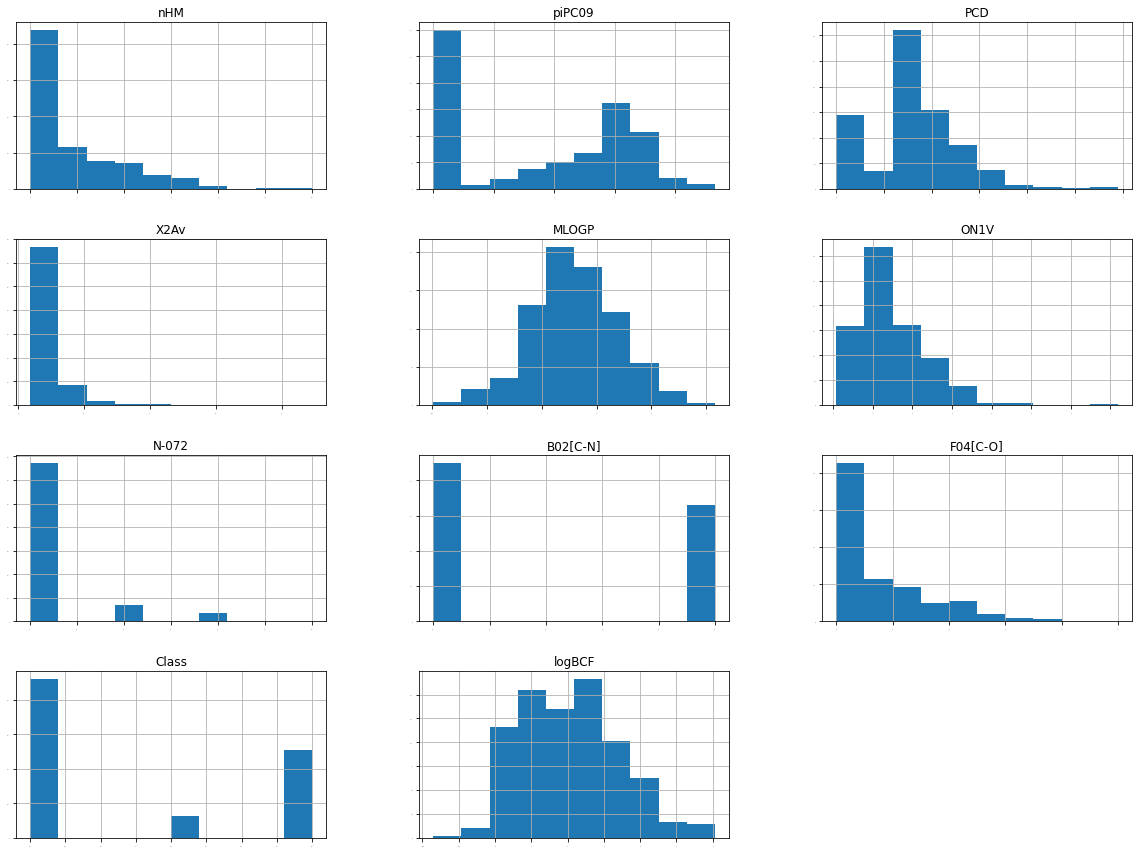

In [4]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1,figsize=(20,15))
plt.show()

For the continuos properties there are:

- 4 left skewed distributions.
- 3 bimodal distributions.

This could be confirmed by using density plots.

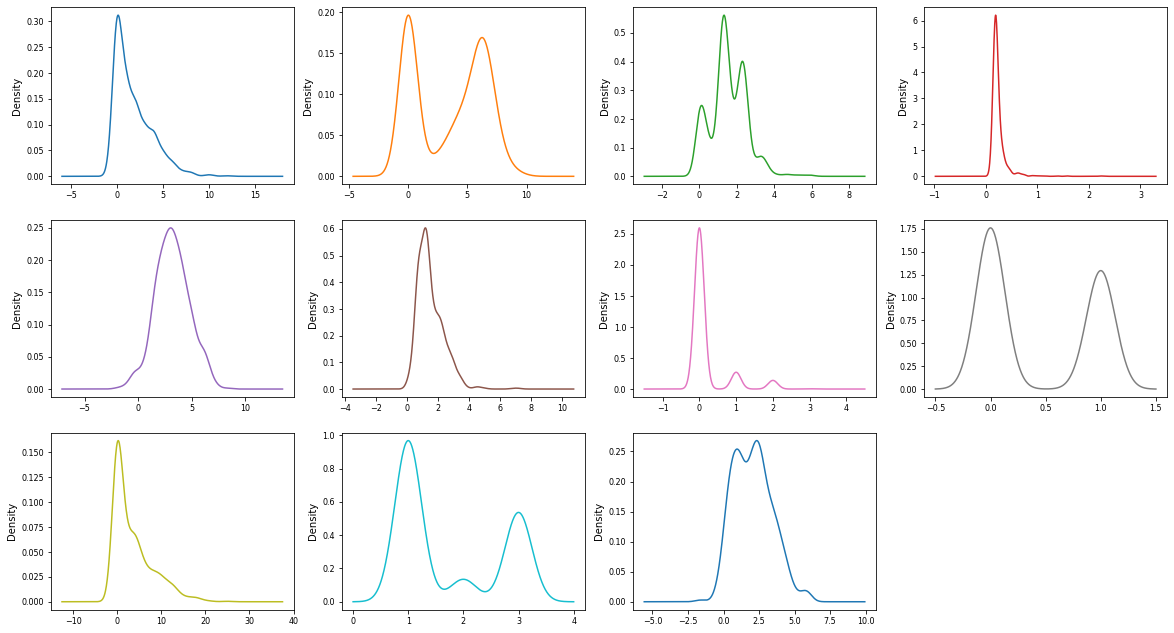

In [5]:
# density plots
dataset.plot(kind='density', subplots=True,layout=(4,4), sharex=False, legend=False, fontsize=8, figsize=(20,15))
plt.show()

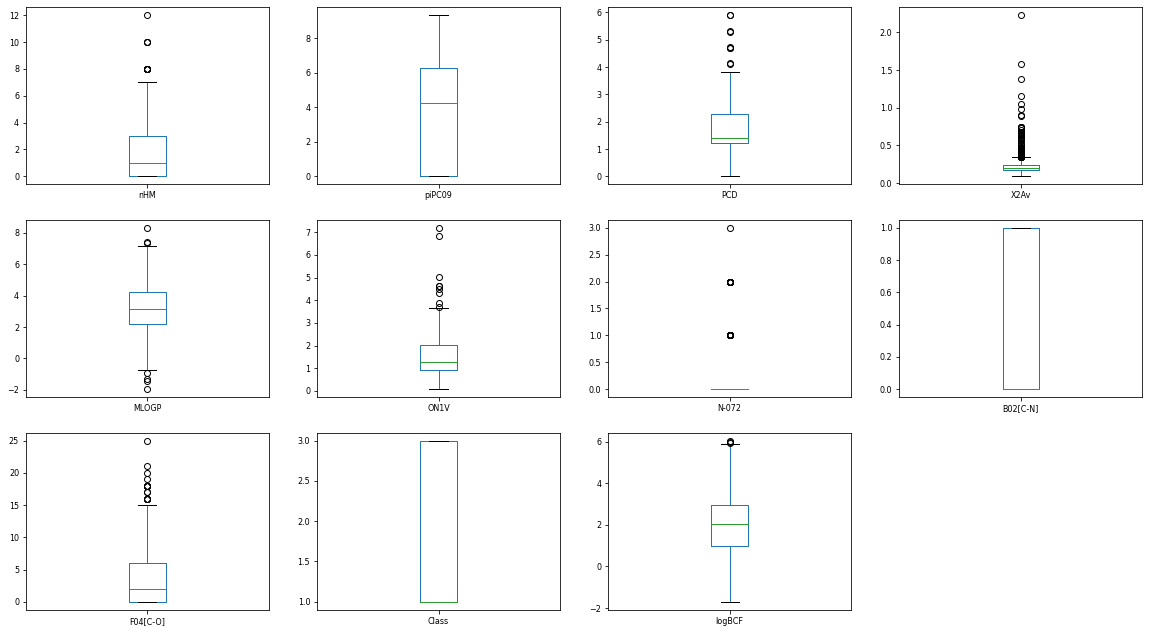

In [6]:
dataset.plot(kind='box', subplots=True,layout=(4,4), sharex=False, sharey=False,fontsize=8, figsize=(20,15))
plt.show()

In [7]:
dataset.drop(['Class'],axis=1, inplace=True)

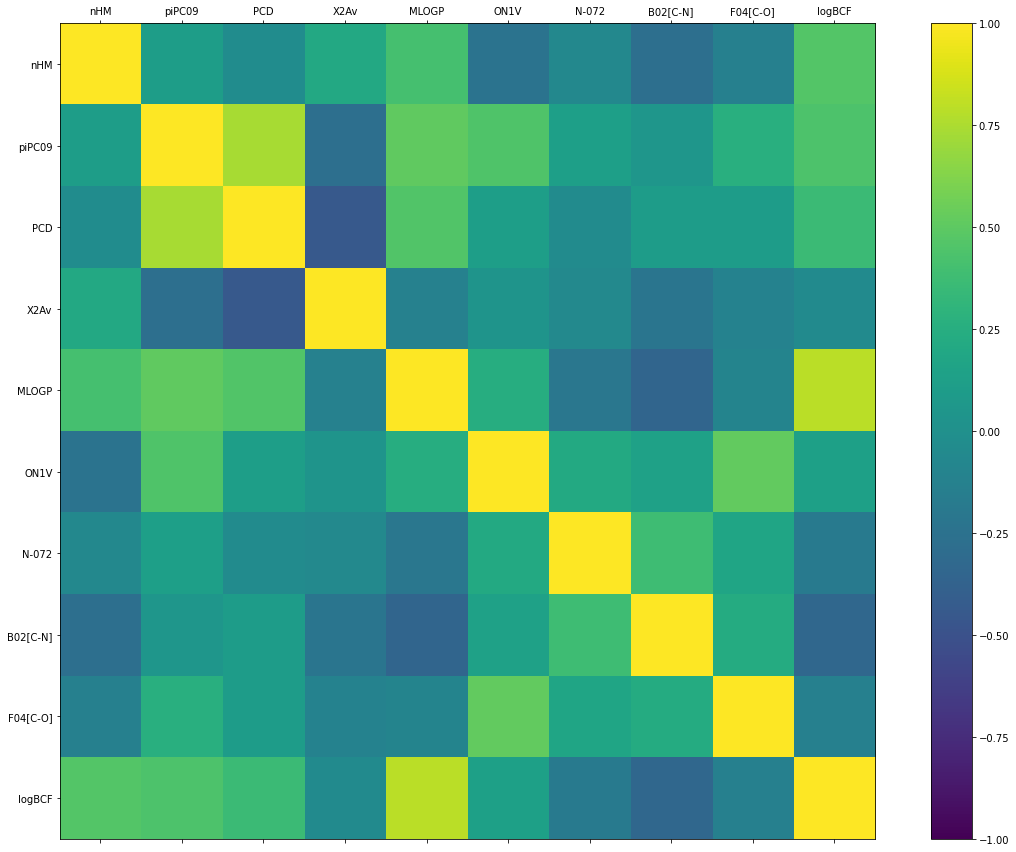

In [8]:
# correlation matrix
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(dataset.columns[3:])
ax.set_yticklabels(dataset.columns[3:])
plt.show()

A weak correlationc na be seen between (PCD, piPC09) and (MLOGP, logBFC).

In [9]:
# split dataset for validation
array = dataset.values
X = array[:,3:12]
Y = array[:,12]
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=validation_size, random_state=seed)

In [10]:
# test options and evaluate metric
num_folds = 10
scoring = 'neg_mean_squared_error'

# collection of algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# evaluation
results =[]
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.659587 (0.197995)
LASSO: -1.079282 (0.120776)
EN: -0.838346 (0.126101)
KNN: -0.619819 (0.212478)
CART: -0.914766 (0.223329)
SVR: -0.546621 (0.159413)


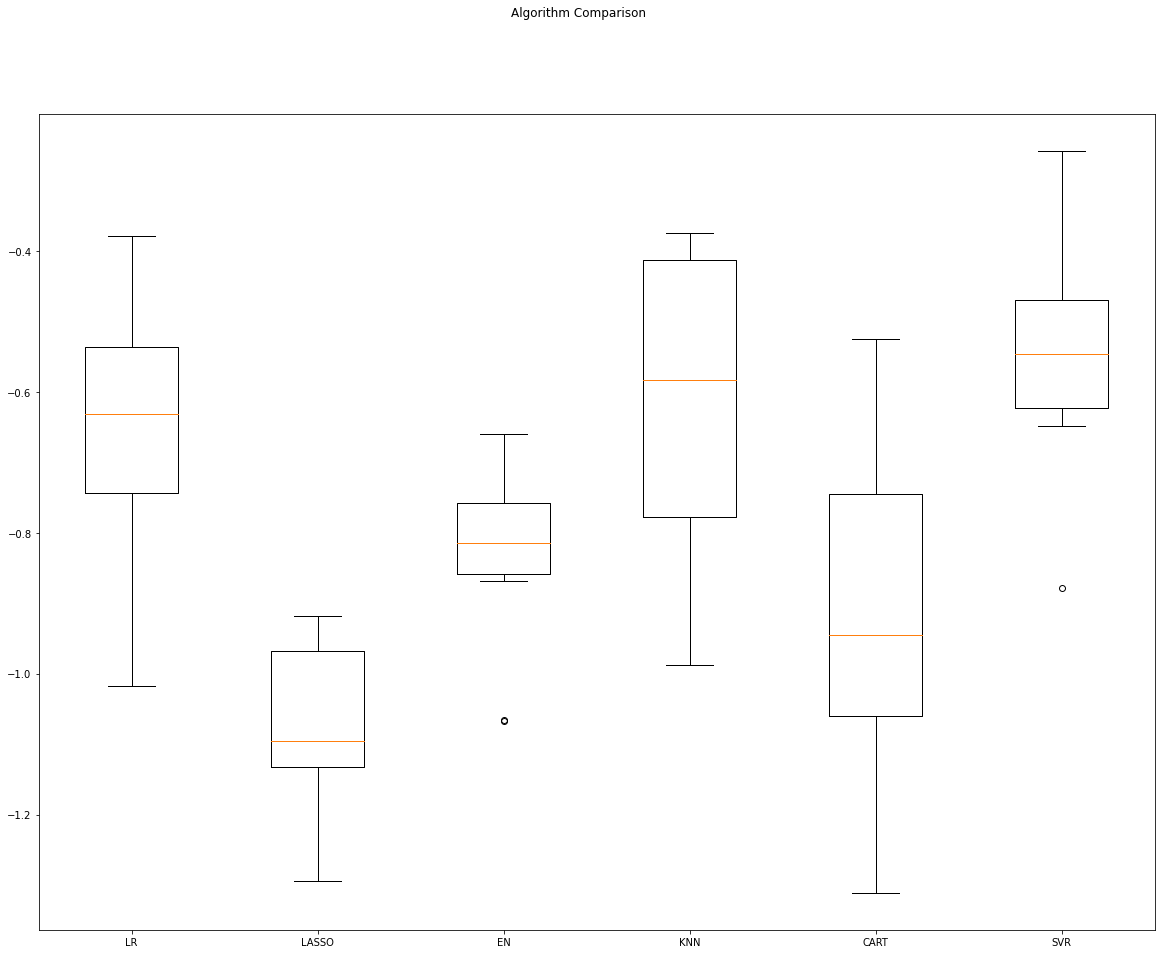

In [11]:
# Compare algorithms
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
fig.suptitle('Algorithm Comparison')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
plt.show()

The best score seems to be yield by the SVR().

Let's try to scale the feature and see if the same models behaves the same.

In [12]:
# standardize dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()), ('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()), ('SVR', SVR())])))

results =[]
names =[]
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.659587 (0.197995)
ScaledLASSO: -1.700558 (0.172030)
ScaledEN: -1.174300 (0.120142)
ScaledKNN: -0.577152 (0.199470)
ScaledCART: -0.871335 (0.220640)
ScaledSVR: -0.534177 (0.148489)


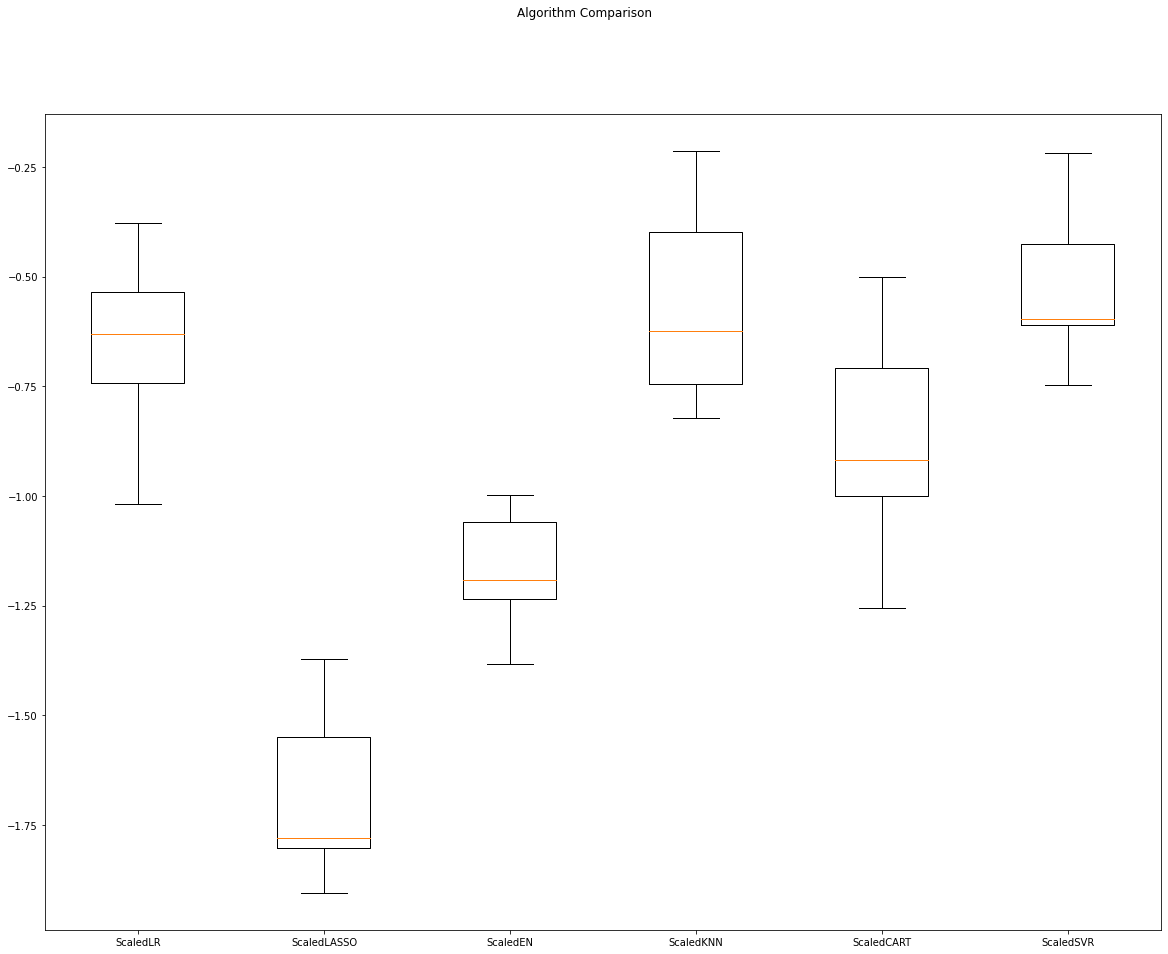

In [13]:
# Compare scaled algorithms 
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
fig.suptitle('Algorithm Comparison')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
plt.show()

Not much of a change.

Let search the best parameters for the SVR() model:

In [14]:
#SVR parameter tuning

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
# param_grid = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
# param_grid = dict(n_neighbors=k_values)
param_grid = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10]}
model = SVR()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, std, param))

Best: -0.532964 using {'C': 1, 'kernel': 'rbf'}
-0.693167 (0.224653) with {'C': 1, 'kernel': 'linear'}
-0.837521 (0.330553) with {'C': 1, 'kernel': 'poly'}
-0.532964 (0.147906) with {'C': 1, 'kernel': 'rbf'}
-20.212975 (5.069025) with {'C': 1, 'kernel': 'sigmoid'}
-0.693594 (0.224970) with {'C': 5, 'kernel': 'linear'}
-1.046705 (0.575917) with {'C': 5, 'kernel': 'poly'}
-0.556584 (0.162642) with {'C': 5, 'kernel': 'rbf'}
-493.376149 (281.284964) with {'C': 5, 'kernel': 'sigmoid'}
-0.693599 (0.224890) with {'C': 10, 'kernel': 'linear'}
-1.223651 (0.863541) with {'C': 10, 'kernel': 'poly'}
-0.586124 (0.168738) with {'C': 10, 'kernel': 'rbf'}
-2297.385002 (583.096266) with {'C': 10, 'kernel': 'sigmoid'}


Out of curiosity, let's see how ensembled models behaves in this problem.

In [16]:
# Ensemble approach for parameters tuning

ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -0.593860 (0.150582)
ScaledGBM: -0.536323 (0.181856)
ScaledRF: -0.539165 (0.214018)
ScaledET: -0.531862 (0.172445)


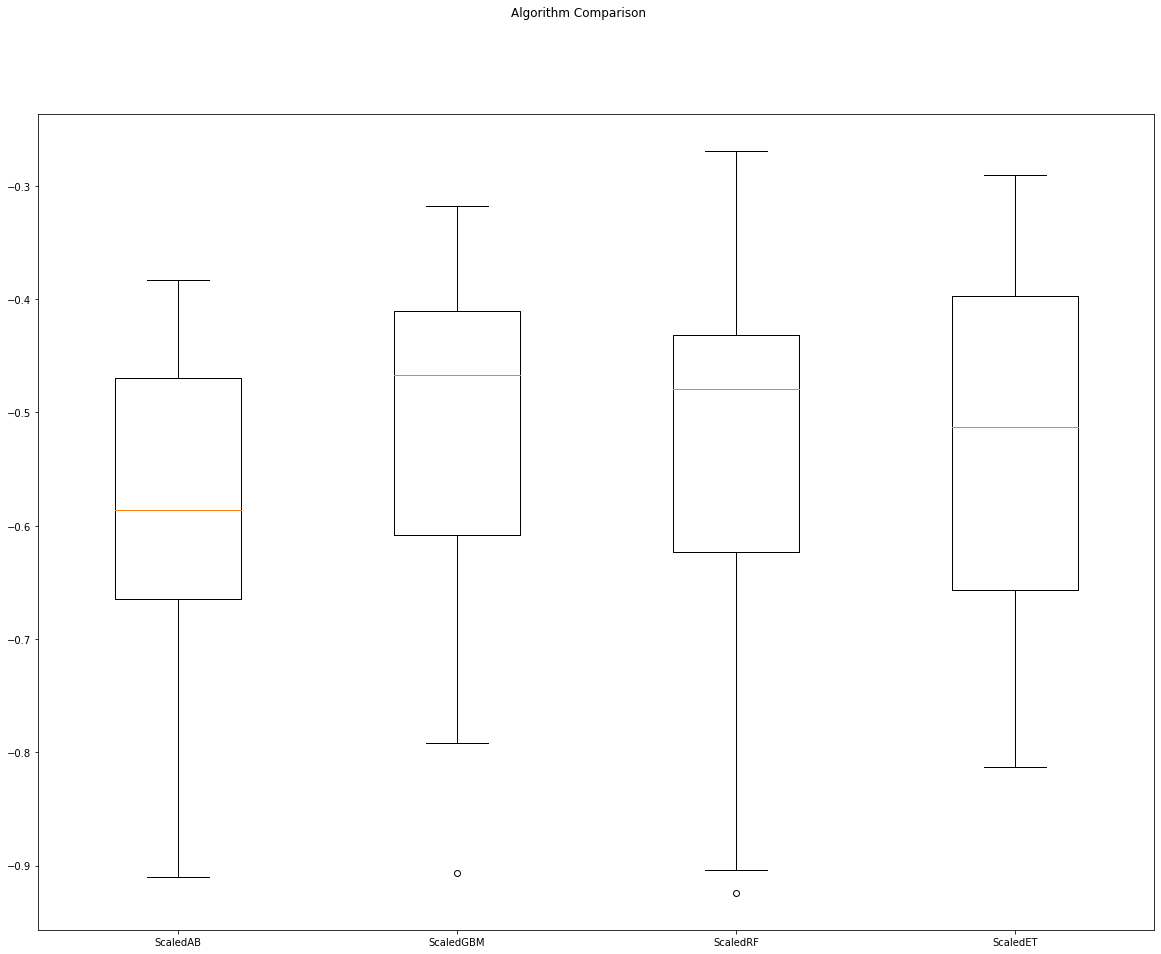

In [17]:
# Compare scaled ensemble algorithms 
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
fig.suptitle('Algorithm Comparison')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
plt.show()

In [18]:
# Tune scale GBM and ET

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, std, param))

Best: -0.537442 using {'n_estimators': 100}
-0.539432 (0.184092) with {'n_estimators': 50}
-0.537442 (0.181962) with {'n_estimators': 100}
-0.543296 (0.184797) with {'n_estimators': 150}
-0.544863 (0.180524) with {'n_estimators': 200}
-0.551743 (0.183626) with {'n_estimators': 250}
-0.553989 (0.182815) with {'n_estimators': 300}
-0.555016 (0.178519) with {'n_estimators': 350}
-0.561988 (0.175507) with {'n_estimators': 400}


In [19]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = ExtraTreesRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, std, param))

Best: -0.520757 using {'n_estimators': 100}
-0.526243 (0.175089) with {'n_estimators': 50}
-0.520757 (0.164709) with {'n_estimators': 100}
-0.525474 (0.170378) with {'n_estimators': 150}
-0.523234 (0.164694) with {'n_estimators': 200}
-0.522231 (0.169630) with {'n_estimators': 250}
-0.526880 (0.172824) with {'n_estimators': 300}
-0.523973 (0.171238) with {'n_estimators': 350}
-0.525710 (0.174000) with {'n_estimators': 400}


In [22]:
# prepare final model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesRegressor(n_estimators=100)
model.fit(rescaledX, Y_train)

# transform validation dataset
rescaledXtest = scaler.transform(X_test)
predictions = model.predict(rescaledXtest)
print(mean_squared_error(Y_test, predictions))

0.4737369875160255
